In [14]:
# Basic Imports
import numpy as np
import h5py as h5
import pandas as pd
from scipy import stats
import pickle
import re
import collections
import tables as tb
from math import isnan
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [15]:
# Data imports
my_name = 'Exp1'
cohort = 'PNC'
clinical_scale = 'PRIME'
exp_name = '{}_{}_{}'.format(my_name,cohort,clinical_scale)

baseline_dir = '/projects/nikhil/PNC/'
csv_file = 'data/prime_wo_age.csv'
csv_data = pd.read_csv(baseline_dir+csv_file)


In [16]:
feature_cols = csv_data.columns[1:13]
label_col = csv_data.columns[13]
X = csv_data[feature_cols].values
y = csv_data[label_col].values

print 'X shape: {}, y shape: {}'.format(X.shape, y.shape)

X shape: (8498, 12), y shape: (8498,)


In [17]:
feature_cols

Index([u'SIP003', u'SIP004', u'SIP005', u'SIP006', u'SIP007', u'SIP008',
       u'SIP009', u'SIP010', u'SIP011', u'SIP012', u'SIP013', u'SIP014'],
      dtype='object')

In [ ]:
select_cols = [0,4,9]
X[:,select_cols]

In [ ]:
# Create folds for CV (default Stratified based on DX)
from sklearn import preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold

stratified_KF = True
if not stratified_KF:
    print 'KFold'
    kf = KFold(len(y), n_folds=10)
else: 
    print 'Stratified KFold'
    kf = StratifiedKFold(y, n_folds=10)
    
for train_index, test_index in kf:    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print 'DX distribution (0,1): {}'.format((np.sum(y[test_index]==0),np.sum(y[test_index]==1)))
    print 'y_train_mean: {}, y_test_mean: {}'.format(np.mean(y_train),np.mean(y_test))
    
save_experimental_setup = True  #Saves X, y, and KF
if save_experimental_setup:
    save_path = '{}exp_setup/CV_{}.pkl'.format(baseline_dir,exp_name)
    exp_setup = {'X': X, 'y': y, 'kf':kf,'exp_name':exp_name}
    pickleIt(exp_setup, save_path)

In [1]:
# Configs for K-fold validations (nested)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
import datetime
import time
import collections
from scipy.stats import mode
from sklearn.metrics import mean_squared_error as mse
import ipyparallel as ipp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
import pickle
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [21]:
#Pick model with its configs/hyper-params
model_list = ['LR_L1', 'RFC']
model_choice_id = 1
model_choice = model_list[model_choice_id]
modality = 'all'

if model_choice == 'LR_L1':
    model_clf = LogisticRegression(penalty='l1',n_jobs=6,class_weight='balanced')
    hyper_params = {'C':[0.01,.1,1,10]} 
    scale_data = False #Scales HC and CT features
    inner_loop = True #only needed to optimize hyper-params
    compute_feat_imp = True    
        
elif model_choice == 'SVR':
    model_clf = SVR()
    hyper_params = {'kernel':['linear','rbf'], 'C':[1,10,25]}
    scale_data = True #Scales HC and CT features
    inner_loop = True #only needed to optimize hyper-params
    compute_feat_imp = True
           
elif model_choice == 'RFC':
    #model_clf = RandomForestClassifier(n_jobs=6,max_depth=3,class_weight='balanced' )
    model_clf = RandomForestClassifier(n_jobs=6,class_weight='balanced' )
    hyper_params = {'n_estimators':[10,50,100,200],'min_samples_split':[2,4,8,16]}
    #hyper_params = {'min_samples_split':[2,4,8,16]}
    scale_data = False
    inner_loop = True #only needed to optimize hyper-params
    compute_feat_imp = True   
    
else:
    print "Unknown model choice"

In [22]:
# Train and Test models
from functools import partial #Parallelize!!! 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from scipy import interp

# Load save experimental setup
baseline_dir = '/projects/nikhil/PNC/'
exp_setup_path = '{}exp_setup/CV_Exp1_PNC_PRIME.pkl'.format(baseline_dir)
exp_setup = pickle.load( open(exp_setup_path, "rb" ) )

X_raw = exp_setup['X']

if scale_data:
    X = preprocessing.scale(X_raw)
else:
    X = X_raw
    
# select specific columns
select_data = False
select_cols = [0,4,9]
if select_data:
    X = X[:,select_cols]

print 'X shape {}'.format(X.shape)

y = exp_setup['y']
kf = exp_setup['kf']
exp_name = exp_setup['exp_name']

#Some paths to store models and performance stats
CV_model_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/output/'
saved_model_name =''
save_model_path = CV_model_dir + exp_name + '_' + model_choice
load_model_path = CV_model_dir + saved_model_name

# train a new classifer? Or load a single pretrained classifier based on most frequent hyperparams found previously?
# This will NOT load K different classifiers each for outer-CV fold  
train_clf = True
save_model = False #do you really want to save all classifiers per each fold? (default false) 

if train_clf:
    # Create list of all the fold-subsets (needed for parallelization)
    X_train = []
    X_valid = []
    y_train = []
    y_valid = []    
    for train, valid in kf:        
        X_train.append(X[train])
        X_valid.append(X[valid])
        y_train.append(y[train])
        y_valid.append(y[valid])

    CV_Acc_train=[] 
    CV_Acc_valid=[] 
    CV_CM_valid=[] #confusion matrix
    CV_AUC_valid=[]    
    CV_fpr_tpr = []
    CV_fpr_tpr_thrsh = []
    CV_prec_recall_thrsh = []
    CV_prec_recall = []
    CV_avg_prec = []
    CV_Class_prob =[]

    predicted_CV_scores = []
    actual_CV_scores = []
    
    # Parallization configs for ipython notebook cluster    
    rc = ipp.Client()
    dview = rc[:]
    dview.push(dict(computeOuterFold = computeOuterFold))
    dview.push(dict(innerCVLoop = innerCVLoop))
    mapfunc = partial(computeOuterFold, model_clf=model_clf, hyper_params=hyper_params, inner_loop=inner_loop, 
                  save_model=save_model, save_model_path=save_model_path)
    parallel_result = dview.map_sync(mapfunc, X_train, y_train, X_valid, y_valid)    
    
    hp_dict = collections.defaultdict(list)
    for pr in parallel_result:
        predicted_CV_scores.append(pr['predicted_fold_score'])
        actual_CV_scores.append(pr['actual_fold_scores'])
        CV_Class_prob.append(pr['Class_prob_valid'])
        
        #Acc
        CV_Acc_train.append(pr['Acc_train'])
        CV_Acc_valid.append(pr['Acc_valid'])                
        
        #Roc - Auc
        fpr, tpr, thresholds = roc_curve(pr['actual_fold_scores'], pr['Class_prob_valid'][:,1]) 
        CV_fpr_tpr.append((fpr,tpr))        
        CV_fpr_tpr_thrsh.append(thresholds)
        CV_AUC_valid.append(roc_auc_score(pr['actual_fold_scores'], pr['Class_prob_valid'][:,1]))
        
        #confusion matrix
        cm = confusion_matrix(pr['actual_fold_scores'], pr['predicted_fold_score'])
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        CV_CM_valid.append(cm_normalized)
        
        #precision-recalls
        precision, recall, thresholds = precision_recall_curve(pr['actual_fold_scores'], pr['Class_prob_valid'][:,1])
        average_precision = average_precision_score(pr['actual_fold_scores'], pr['Class_prob_valid'][:,1])        
        CV_prec_recall.append((precision, recall))
        CV_avg_prec.append(average_precision)
        CV_prec_recall_thrsh.append(thresholds)
                        
        for hp in hyper_params:
            hp_dict[hp].append(pr['hp_dict'][hp])
            
    #Find out most frequent hyper-params during cross-val    
    hp_mode = {}
    for hp in hyper_params:
        hp_mode[hp] = mode(hp_dict[hp])[0][0]

    print 'most frequent hp:' + str(hp_mode)
    
else: 
    #Grabs the best classifer as a result of N-fold nested CV along with the MSE and R2 stats of the outerloop
    print "Loading previously saved model: "
    f = open(load_model_path)
    result = pickle.load(f)
    test_clf = result['best_clf']
    CV_r_valid = result['CV_r']
    CV_R2_valid = result['CV_R2']
    CV_MSE_valid = result['CV_MSE']
    f.close()

print 'CV Acc (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_Acc_valid),stats.sem(CV_Acc_valid))
print 'CV AUC (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_AUC_valid),stats.sem(CV_AUC_valid))
print 'CV Confusion Matrix (mean): {}'.format(np.mean(np.array(CV_CM_valid),axis=0))
#print 'CV precision recall: {}'.format(CV_prec_recall)
print 'CV avg precision: {}'.format(CV_avg_prec)

X shape (8498, 12)
most frequent hp:{'n_estimators': array([200]), 'min_samples_split': array([2])}
CV Acc (mean, std_err): 0.93, 0.00
CV AUC (mean, std_err): 0.90, 0.01
CV Confusion Matrix (mean): [[ 0.97483399  0.02516601]
 [ 0.28303729  0.71696271]]
CV avg precision: [0.84989197751715917, 0.85208144694263876, 0.87420956367204439, 0.78611444738891834, 0.81483694960780362, 0.85786982439394499, 0.85683471658783816, 0.85005905832043926, 0.86403248092270413, 0.80649710500076588]


In [ ]:
# check feature importance (QC for HC importance)

# for fid in np.arange(10):
#     model_clf.fit(X_train[fid],y_train[fid])
#     feat_imp = model_clf.feature_importances_
#     print np.argsort(feat_imp)

#inf tree depth
most frequent hp:{'n_estimators': array([200]), 'min_samples_split': array([2])}
CV Acc (mean, std_err): 0.93, 0.00
CV AUC (mean, std_err): 0.84, 0.01
CV Confusion Matrix (mean): [[ 0.97411416  0.02588584]
 [ 0.28624633  0.71375367]]

#tree depth max = 3
X shape (8498, 12)
most frequent hp:{'n_estimators': array([100]), 'min_samples_split': array([8])}
CV Acc (mean, std_err): 0.85, 0.00
CV AUC (mean, std_err): 0.82, 0.01
CV Confusion Matrix (mean): [[ 0.86626726  0.13373274]
 [ 0.22276079  0.77723921]]


In [ ]:
feature_importance
print sorted_idx

In [24]:
# Compute single model from the most frequent hyper-params (for across dataset testing)
save_model_path = baseline_dir + 'exp_results/'
exp_name = 'Exp1_f3'

#test_clf = LogisticRegression(C=1)    
#test_clf = SVR(kernel='rbf',C=10)
test_clf = RandomForestClassifier(n_estimators=200,min_samples_split=2,n_jobs=4)

CV_feat_imp=[]
if compute_feat_imp:
    for fid in np.arange(10):
        test_clf.fit(X_train[fid],y_train[fid])
        if model_choice == 'RFC':
            feat_imp = test_clf.feature_importances_
        elif model_choice == 'LR_L1':
            feat_imp = test_clf.coef_ 
            
        CV_feat_imp.append(feat_imp)
        #print zip(np.argsort(feat_imp), np.sort(feat_imp))

save_CV_perf = False
if save_CV_perf:
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    save_model_filename = save_model_path + model_choice + '_' + exp_name + '_' + st + '.pkl'
    classifier_model_and_stats = {'best_clf':test_clf, 'CV_CM_valid':CV_CM_valid, 'CV_AUC_valid':CV_AUC_valid,
                                  'CV_feat_imp':CV_feat_imp, 'CV_fpr_tpr':CV_fpr_tpr, 'CV_fpr_tpr_thrsh':CV_fpr_tpr_thrsh, 
                                  'CV_prec_recall': CV_prec_recall, 'CV_prec_recall_thrsh':CV_prec_recall_thrsh,
                                  'CV_avg_prec':CV_avg_prec}    
    pickleIt(classifier_model_and_stats,save_model_filename)

saving figure to: /projects/nikhil/PNC/exp_results/


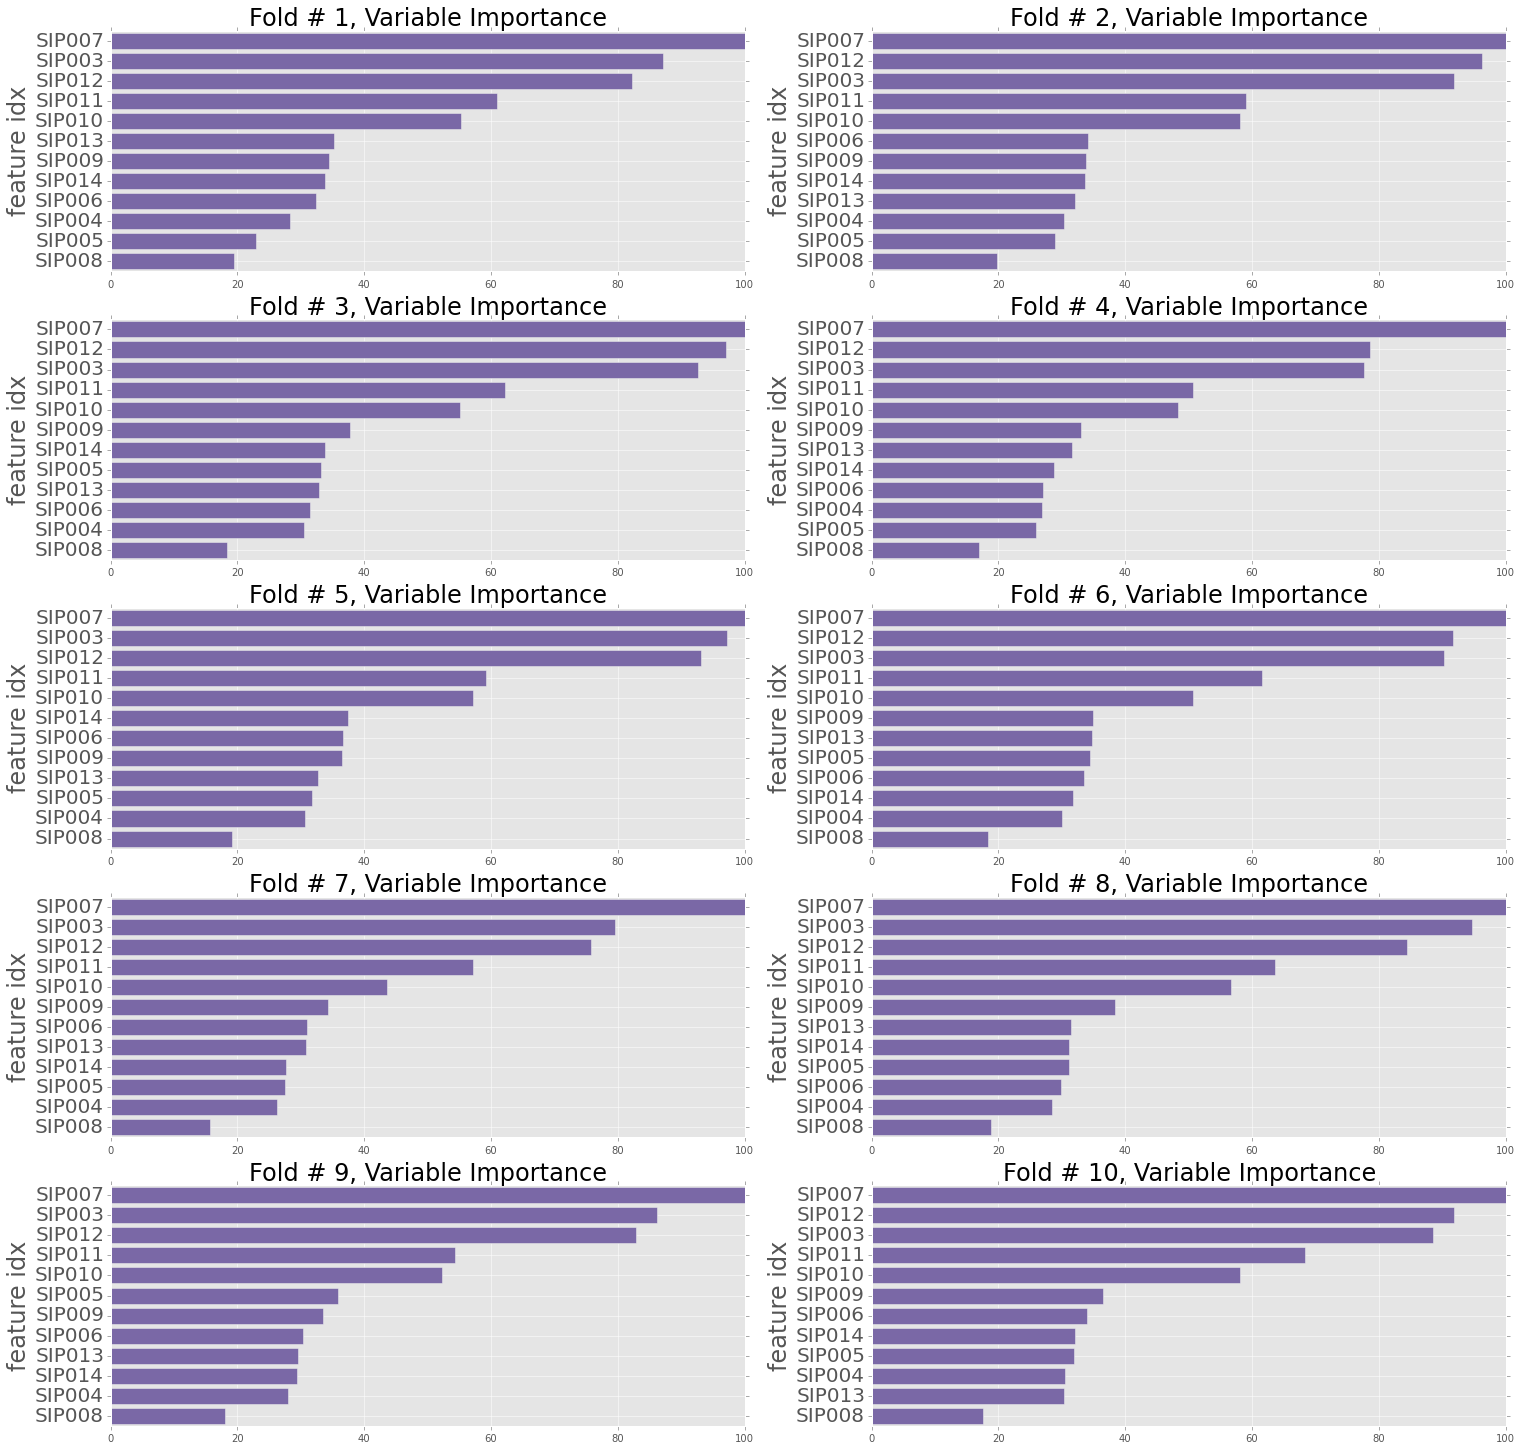

In [25]:
#plots
plt.style.use('ggplot') # Good looking plots
fontsize_large = 24
fontsize_mid = 20
n_folds = len(CV_feat_imp)
cols = 2
rows = np.ceil(n_folds/cols)
save_model_path = baseline_dir + 'exp_results/'

# feature imp
plot_feat_imp = True
if plot_feat_imp:
    plot_name = 'variable_importance'
    plt.rcParams['figure.figsize'] = (25, 25)
    for fid, feature_importance in enumerate(CV_feat_imp):
        # Get Feature Importance from the classifier
        # Normalize The Features
        feature_importance = np.squeeze(feature_importance)
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        plt.subplot(rows,cols,fid+1)
        #plt.figure(figsize=(16, 12))
        plt.barh(pos, feature_importance[sorted_idx], align='center', color='#7A68A6')
        plt.yticks(pos, feature_cols[sorted_idx],fontsize=fontsize_mid)
        plt.ylabel('feature idx',fontsize=fontsize_large)
        #plt.xlabel('Variable Importance',fontsize=fontsize_large)
        plt.title('Fold # {}, Variable Importance'.format(fid+1),fontsize=fontsize_large)
        
# confusion matrix
plot_CM = False
if plot_CM:
    plot_name = 'Confusion_Matrix'
    plt.rcParams['figure.figsize'] = (25, 25)
    class_labels = ['Control','Patient']
    for fid, cm in enumerate(CV_CM_valid):
        plt.subplot(rows,cols,fid+1)
        plt.imshow(cm, interpolation='nearest',cmap=plt.cm.Blues)
        plt.colorbar()
        tick_marks = np.arange(len(class_labels))
        plt.xticks(tick_marks, class_labels)
        plt.yticks(tick_marks,class_labels, rotation=90)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.grid()
        # annotate confusion entries
        width = len(cm)
        height = len(cm[0])

        for x in xrange(width):
            for y in xrange(height):
                plt.annotate('{0:.3f}'.format(cm[x][y]), xy=(y, x), horizontalalignment='center',
                            verticalalignment='center',fontsize=fontsize_large)

#roc and auc
plot_roc = False
if plot_roc:
    plot_name = 'ROC'
    plt.rcParams['figure.figsize'] = (15, 15)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (fpr, tpr) in enumerate(CV_fpr_tpr):                
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(CV_fpr_tpr)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

#Save figure
save_fig = True
if save_fig:
    print "saving figure to: {}".format(save_model_path)
    box_fig = plt.gcf()
    box_fig.savefig('{}{}_{}_{}.png'.format(save_model_path, model_choice,plot_name,exp_name), bbox_inches='tight')


In [4]:
# Some Defs
def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f)
    f.close()

#Outer Fold Computation (need the imports inside def if you want to parallelize!)
def computeOuterFold(train_X, train_y, valid_X, valid_y, model_clf, hyper_params, inner_loop, save_model, save_model_path):
    import collections
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import grid_search    
    import collections
    from scipy.stats import mode    
    from scipy import stats
    
    print 'Starting Outerfold computation'
    
    hp_dict = collections.defaultdict(list) #store best hyper-parameters for each fold
    
    if inner_loop:     
        print 'Starting InnerFold computation'
        save_model_path_fold = save_model_path + '_fold_' 
        clf = innerCVLoop(model_clf,hyper_params,train_X, train_y,save_model,save_model_path_fold)
        for hp in hyper_params:
            hp_dict[hp].append(clf.best_estimator_.get_params()[hp])
            
        print 'Ending InnerFold computation'

    else:
        clf = model_clf
        clf.fit(fold_X,fold_y)
                
    Acc_train = clf.score(train_X,train_y) 
    Acc_valid = clf.score(valid_X,valid_y)
    Class_prob_valid = clf.predict_proba(valid_X)
    
    #feature imp (issue with the innerCVLoop)
    #clf.fit(train_X,train_y)
    #feat_imp = clf.feature_importances_
        
    print 'Ending OuterFold computation'
    
    return {'Acc_train':Acc_train,'Acc_valid':Acc_valid, 'hp_dict':hp_dict, 
            'predicted_fold_score': clf.predict(valid_X), 'actual_fold_scores':valid_y,'Class_prob_valid':Class_prob_valid}

#Inner Fold Computation (need the imports inside def if you want to parallelize!)
def innerCVLoop(model_clf,hyper_params,fold_X, fold_y,save_model,save_model_path):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import grid_search
    clf = grid_search.GridSearchCV(model_clf, hyper_params,cv=3,verbose=0)
    clf.fit(fold_X, fold_y)
    #Save classifier
    if save_model:
        save_model(clf,save_model_path)
        
    return clf

def autolabel(rects,_ax):
    for rect in rects:
        height = rect.get_height()
        _ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '{:03.2f}'.format(height),
                ha='center',            # vertical alignment
                va='bottom',             # horizontal alignment
                fontsize = 25)
